# Notebook Initialization

In [1]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
images_pp_dir = data_dir / "COVID19-preprocessed"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Explainability (Saliency/Integrated Gradients)

In [4]:
from matplotlib import pyplot as plt
import numpy as np

In [5]:
from tensorflow.keras.models import load_model
cnn_model_suffix = "07"
model_file = models_dir / f"feature_extractor_{cnn_model_suffix}.tf"
model = load_model(str(model_file))

model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 64, 64, 6)         168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 32, 32, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 16, 16, 18)        1962      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 8, 8, 18)     

In [6]:
test_df = repo.load("test_df")
test_df.head(5)

,label,file,patient_id,scan_id,n_slice,num_clips,seq_num,clip_num
0,CP,CP/1/3143/0275.png,1,3143,300,1,0,0
1,CP,CP/1/3143/0064.png,1,3143,300,1,1,0
2,CP,CP/1/3143/0083.png,1,3143,300,1,2,0
3,CP,CP/1/3143/0160.png,1,3143,300,1,3,0
4,CP,CP/1/3143/0286.png,1,3143,300,1,4,0


In [14]:
from keras_preprocessing.image import ImageDataGenerator

img_size = 64
image_target_size = (img_size, img_size)
seed = config.get_int("tfg.seed")
batch_size = config.get_int("tfg.training.batch_size")
imgs_output = docs_dir / "explainability"

# test_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(
    rescale=1./255.,
#     rotation_range=180,
#     zoom_range=[.5, 1.]
)

explainability_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=str(images_input_dir),
    x_col="file",
    y_col="label",
    batch_size=batch_size,
    seed=seed,
    shuffle=True,
    class_mode="categorical",
    target_size=image_target_size)

Found 40415 validated image filenames belonging to 3 classes.


In [15]:
images_to_explain = explainability_generator.next()
images_to_explain[0].shape, images_to_explain[1].shape
file_start_idx = (explainability_generator.batch_index - 1) * explainability_generator.batch_size
images_to_explain_files = explainability_generator.filenames[file_start_idx : file_start_idx + explainability_generator.batch_size]

In [16]:
class_to_idx = explainability_generator.class_indices
idx_to_class = { v: k for k, v in class_to_idx.items() }

print(f"{class_to_idx}")
print(f"{idx_to_class}")

{'CP': 0, 'NCP': 1, 'Normal': 2}
{0: 'CP', 1: 'NCP', 2: 'Normal'}


In [17]:
from tfg.utils.integrated_gradients import plot_saliency_and_img_attributions

In [18]:
import matplotlib.pyplot as plt

Adding explainability for input file CP/1/3143/0275.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0275.png


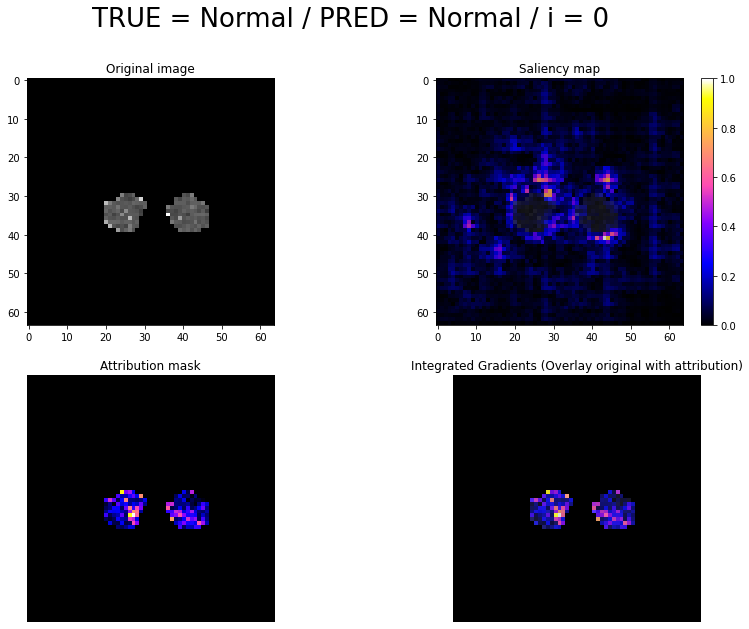

Adding explainability for input file CP/1/3143/0064.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0064.png


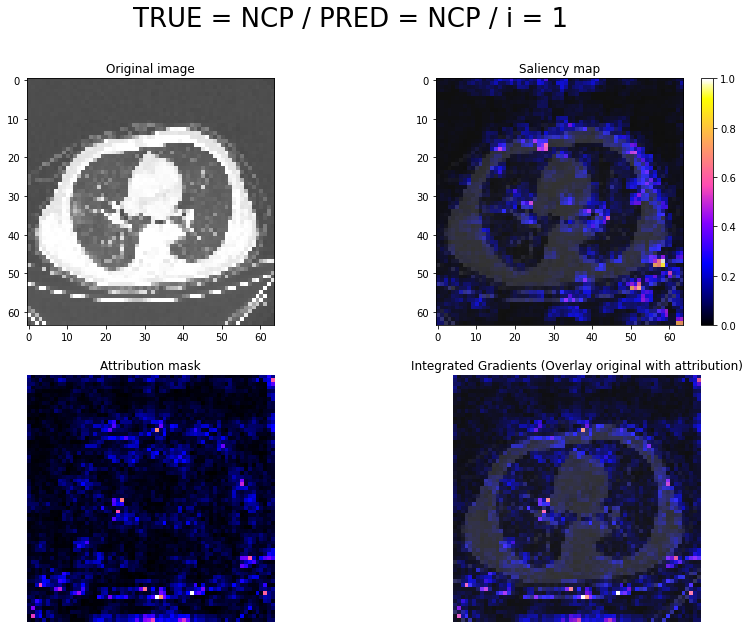

Adding explainability for input file CP/1/3143/0083.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0083.png


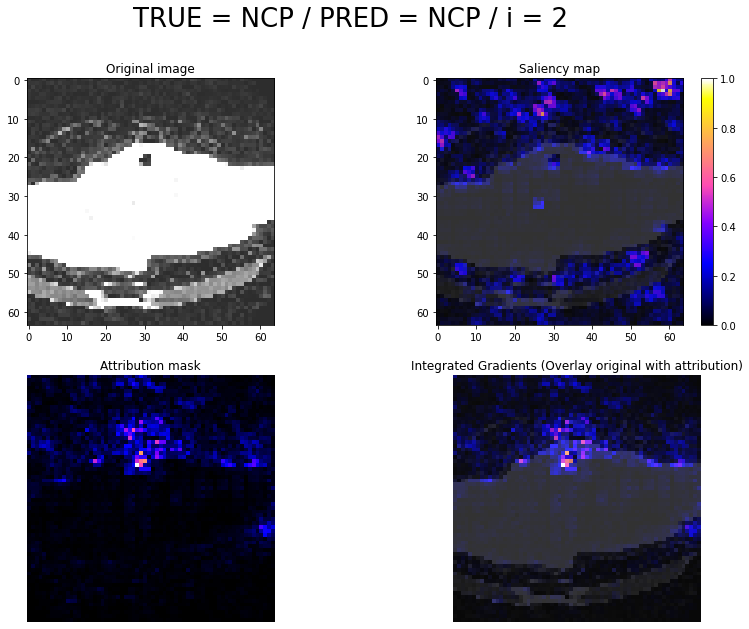

Adding explainability for input file CP/1/3143/0160.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0160.png


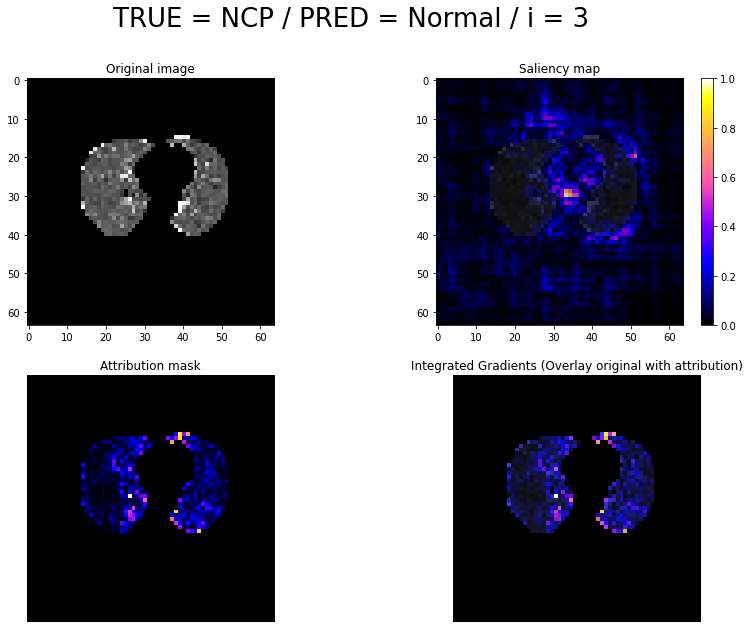

Adding explainability for input file CP/1/3143/0286.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0286.png


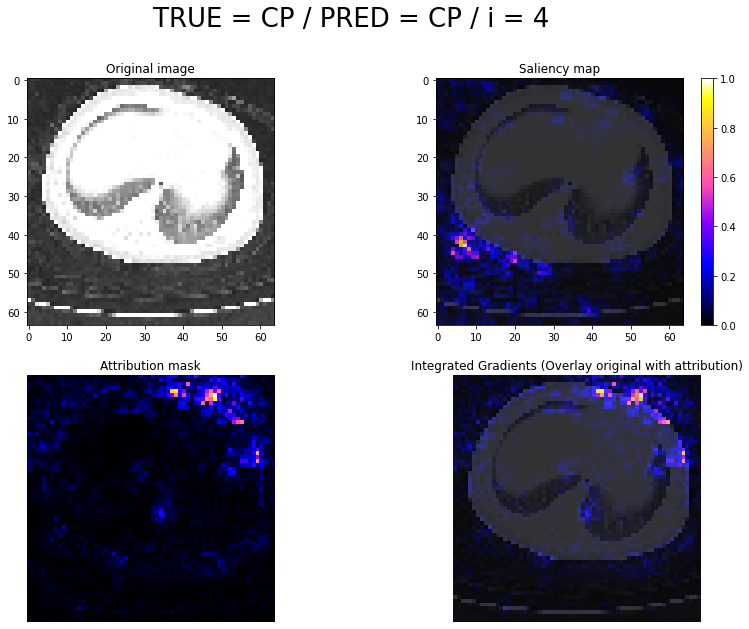

Adding explainability for input file CP/1/3143/0127.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0127.png


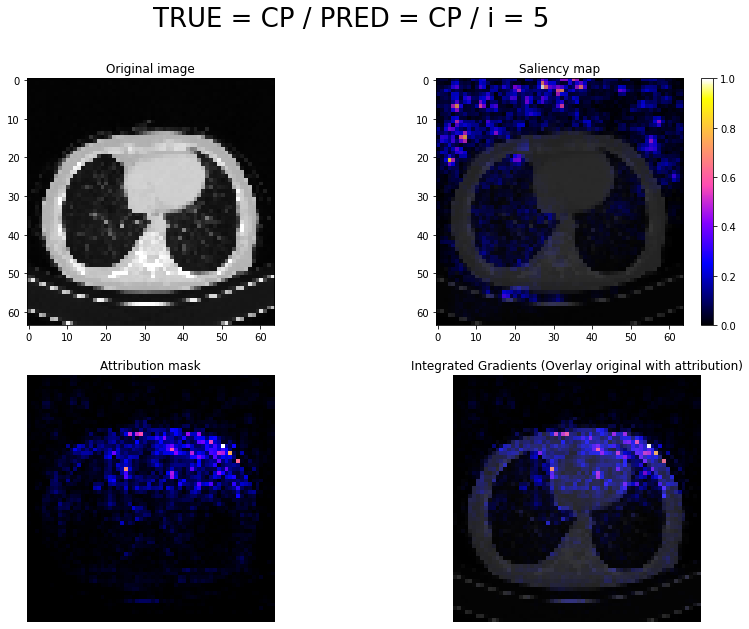

Adding explainability for input file CP/1/3143/0205.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0205.png


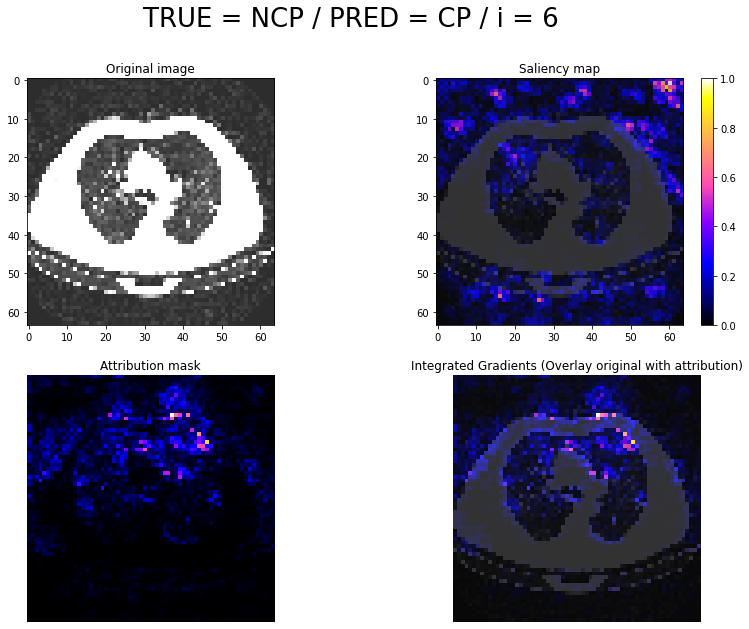

Adding explainability for input file CP/1/3143/0186.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0186.png


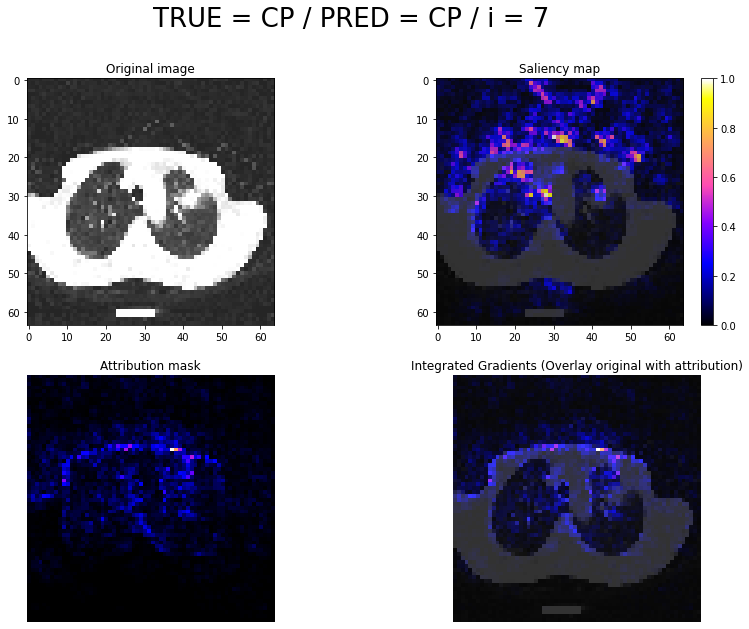

Adding explainability for input file CP/1/3143/0233.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0233.png


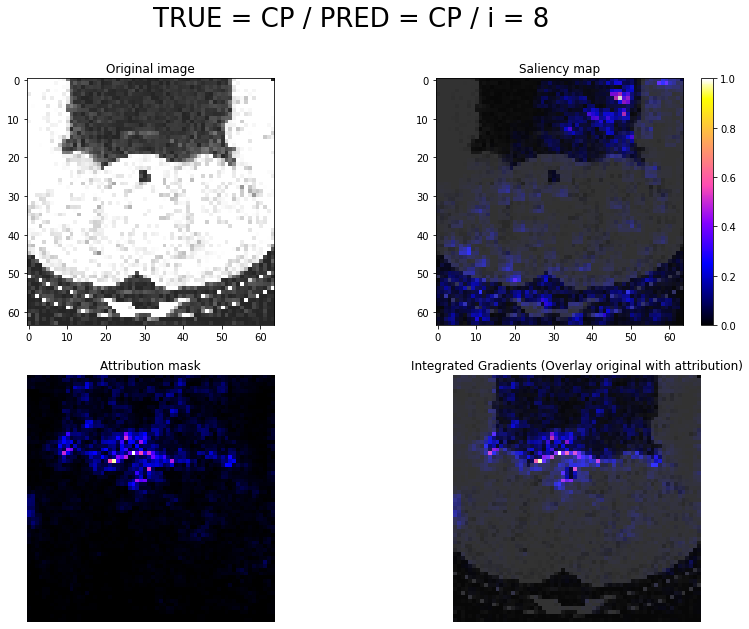

Adding explainability for input file CP/1/3143/0099.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0099.png


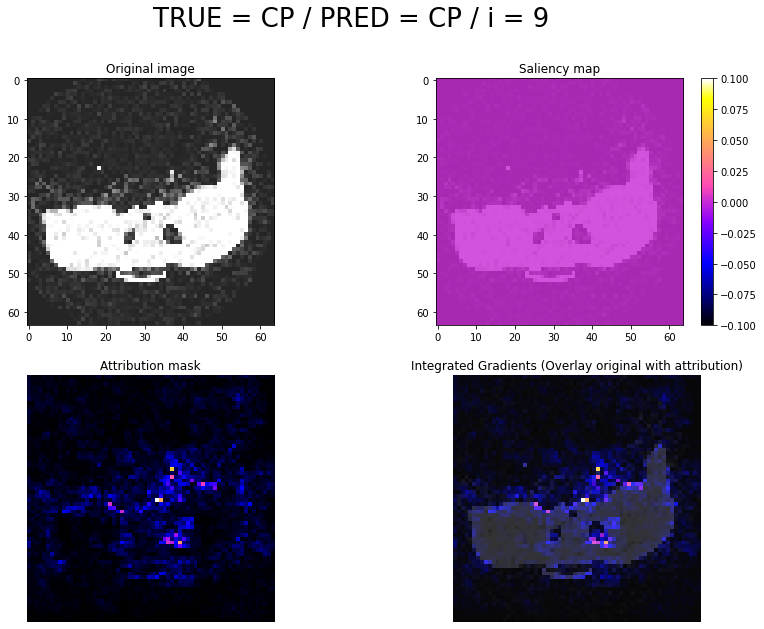

Adding explainability for input file CP/1/3143/0174.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0174.png


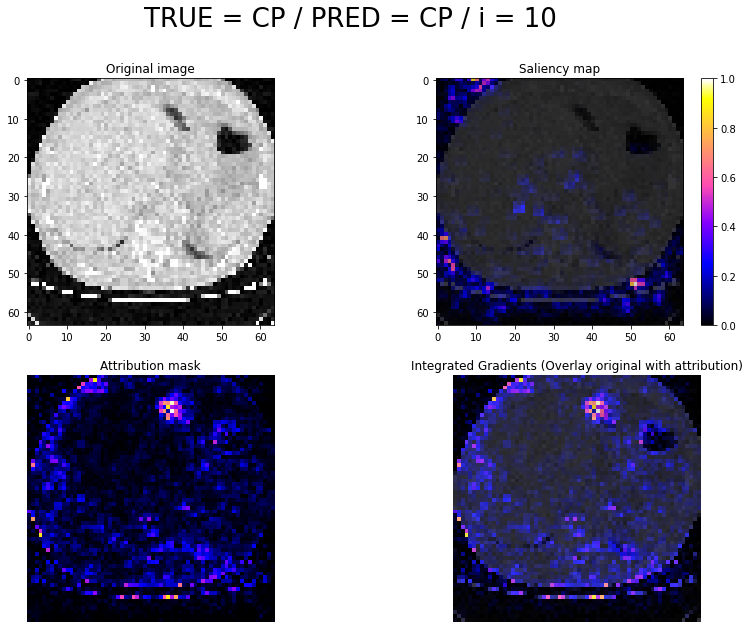

Adding explainability for input file CP/1/3143/0011.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0011.png


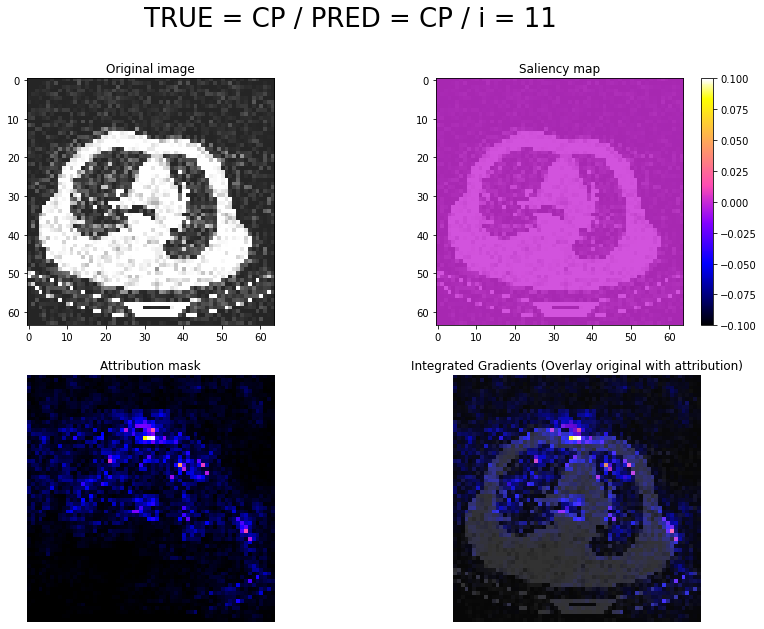

Adding explainability for input file CP/1/3143/0140.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0140.png


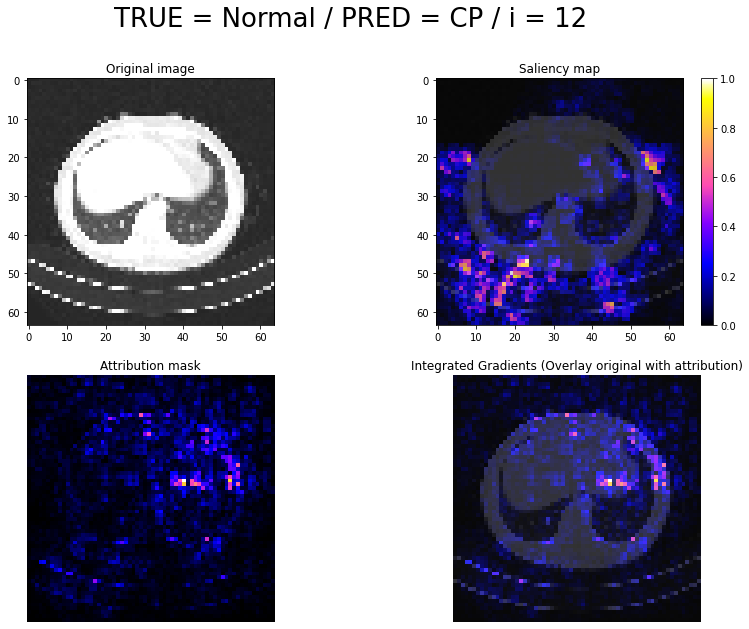

Adding explainability for input file CP/1/3143/0050.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0050.png


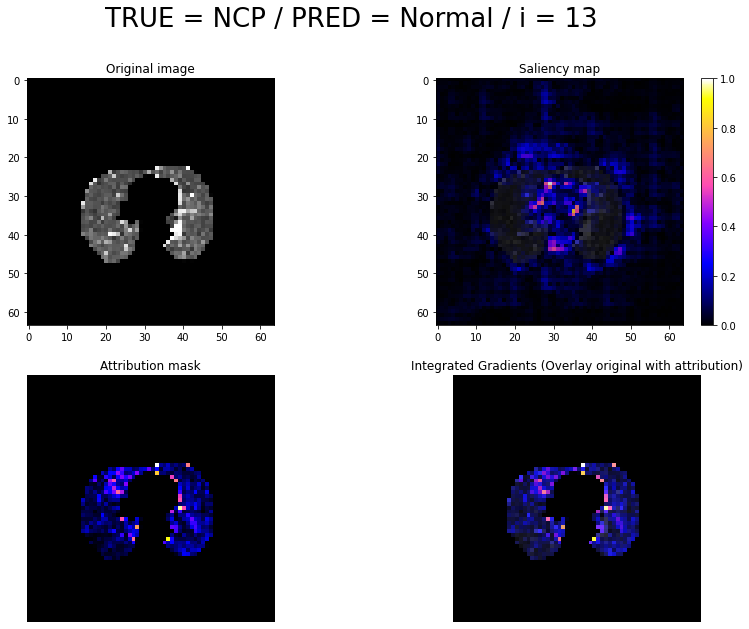

Adding explainability for input file CP/1/3143/0239.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0239.png


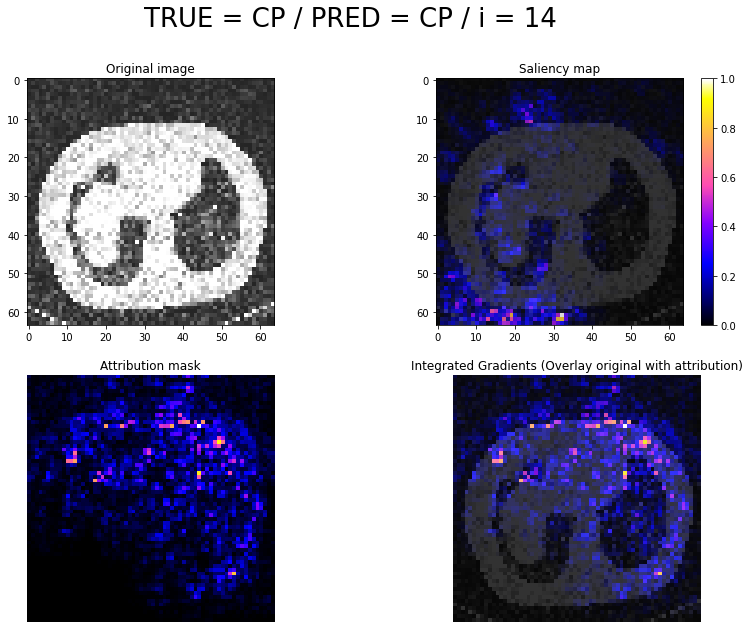

Adding explainability for input file CP/1/3143/0190.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0190.png


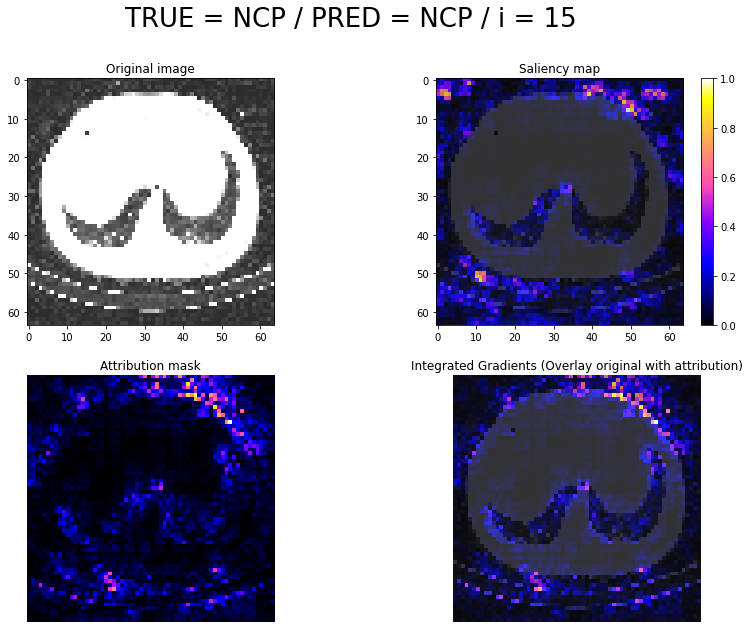

Adding explainability for input file CP/1/3143/0066.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0066.png


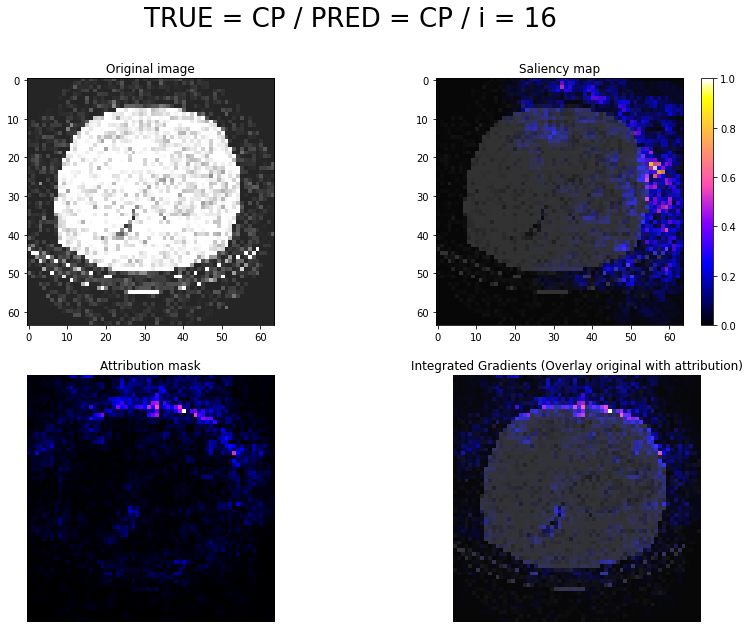

Adding explainability for input file CP/1/3143/0226.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0226.png


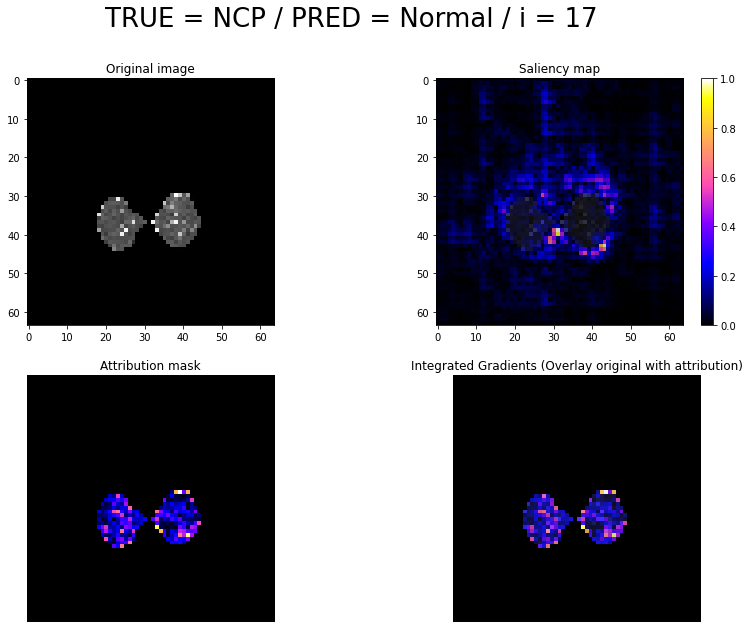

Adding explainability for input file CP/1/3143/0152.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0152.png


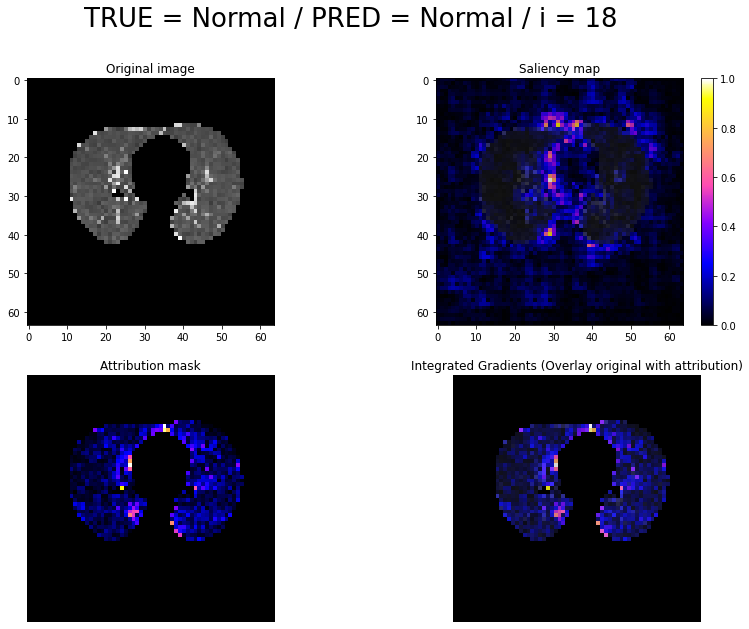

Adding explainability for input file CP/1/3143/0214.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0214.png


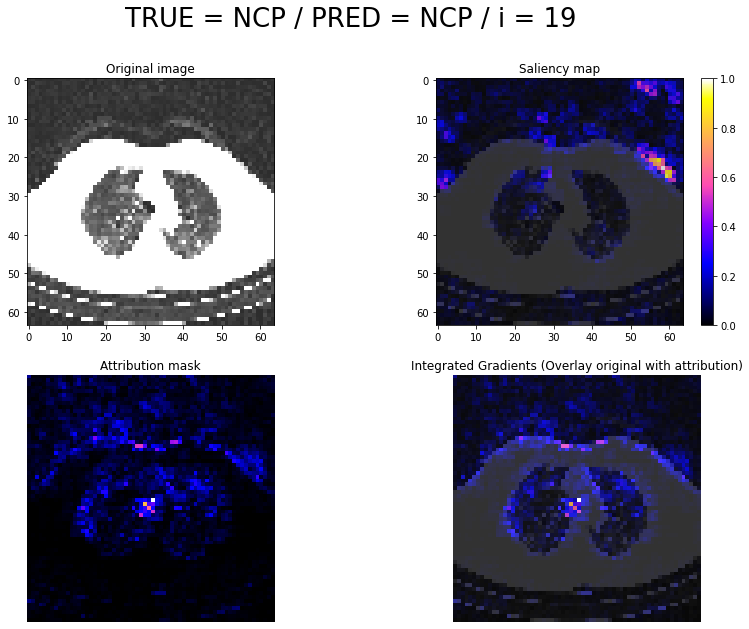

Adding explainability for input file CP/1/3143/0024.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0024.png


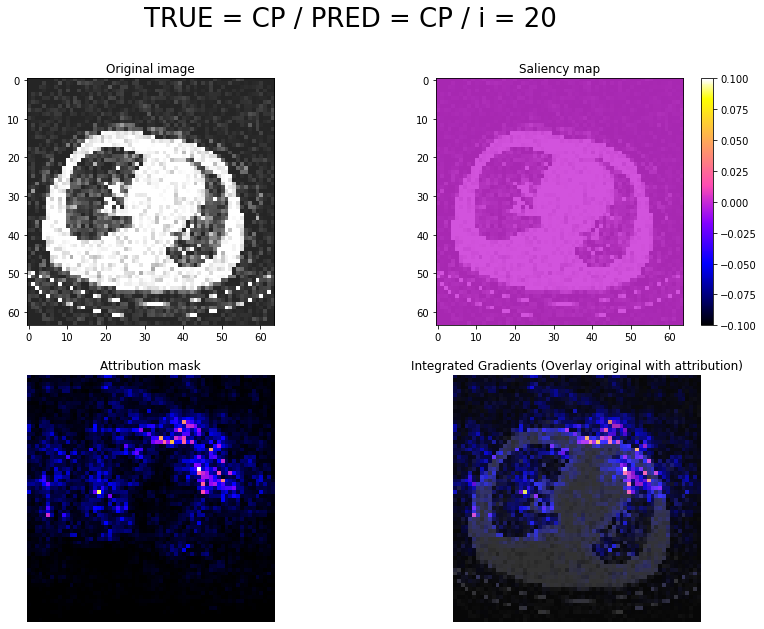

Adding explainability for input file CP/1/3143/0074.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0074.png


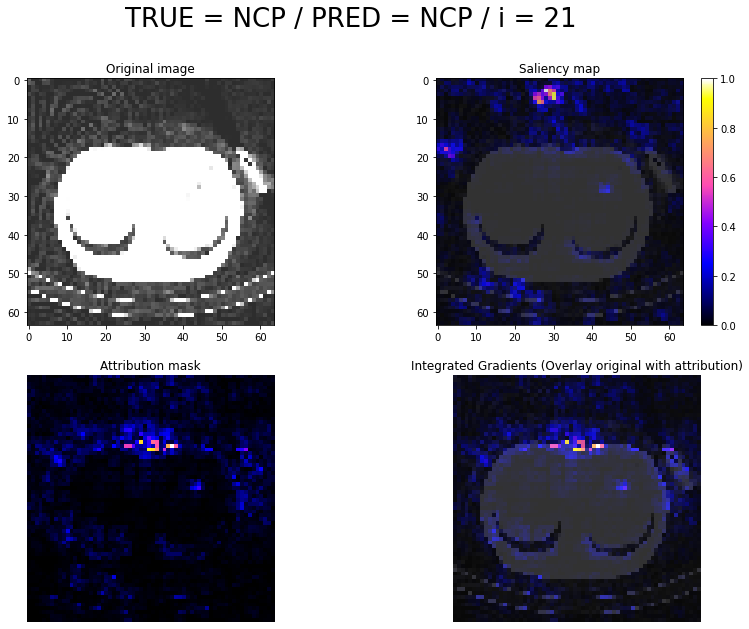

Adding explainability for input file CP/1/3143/0234.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0234.png


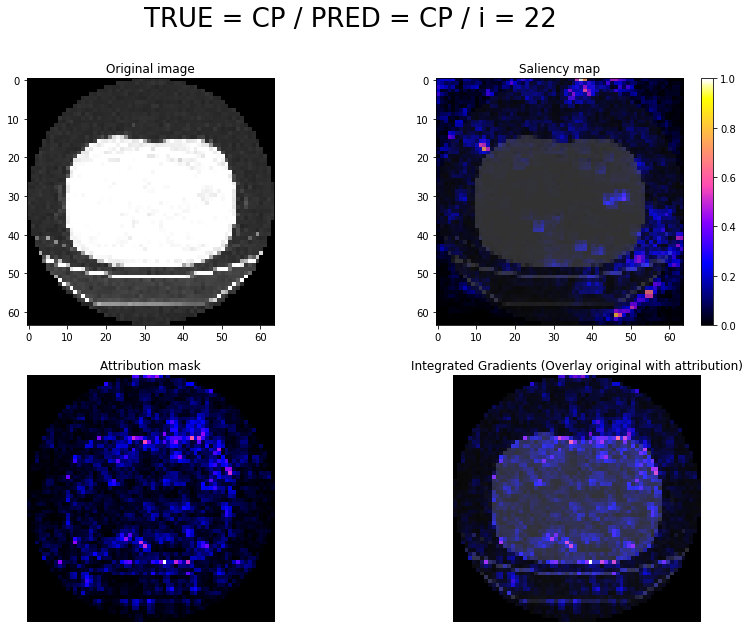

Adding explainability for input file CP/1/3143/0182.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0182.png


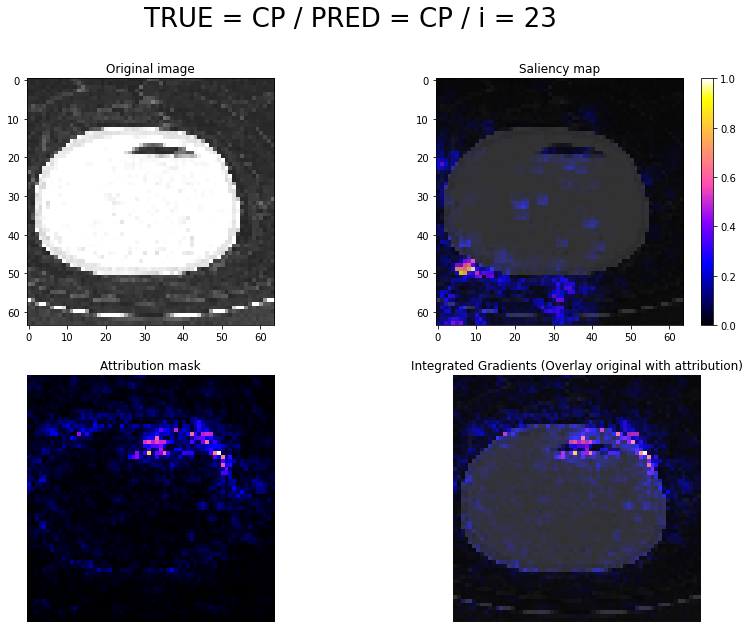

Adding explainability for input file CP/1/3143/0130.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0130.png


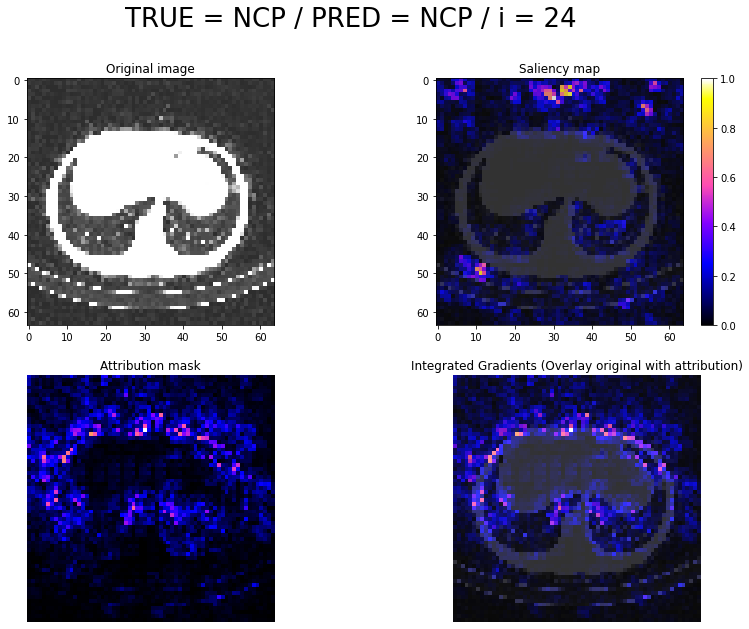

Adding explainability for input file CP/1/3143/0149.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0149.png


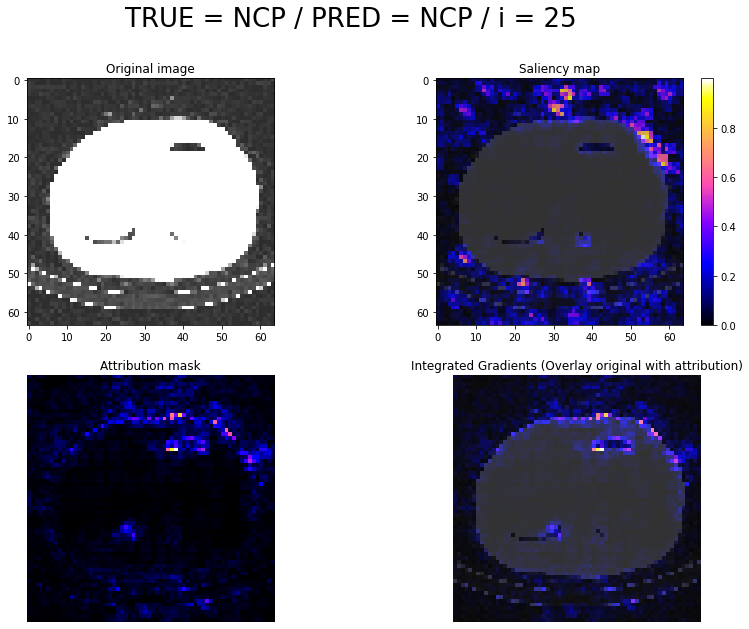

Adding explainability for input file CP/1/3143/0232.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0232.png


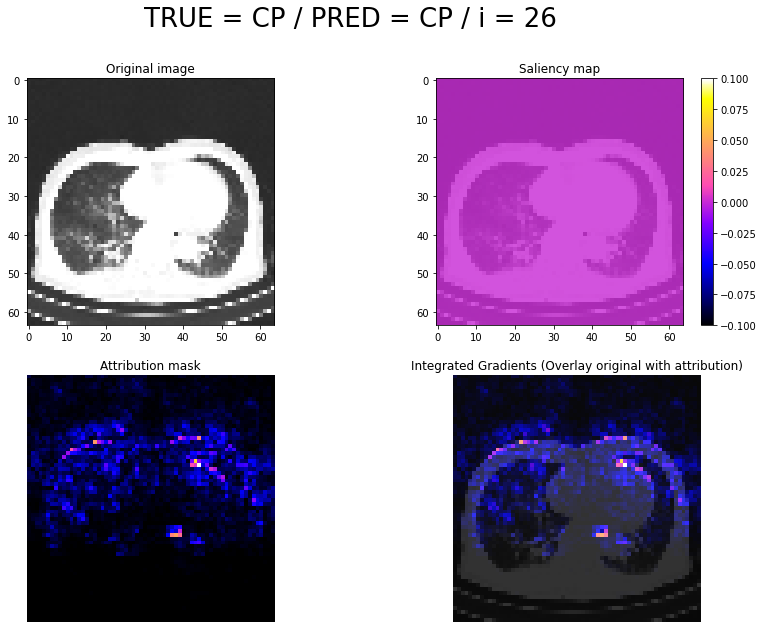

Adding explainability for input file CP/1/3143/0215.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0215.png


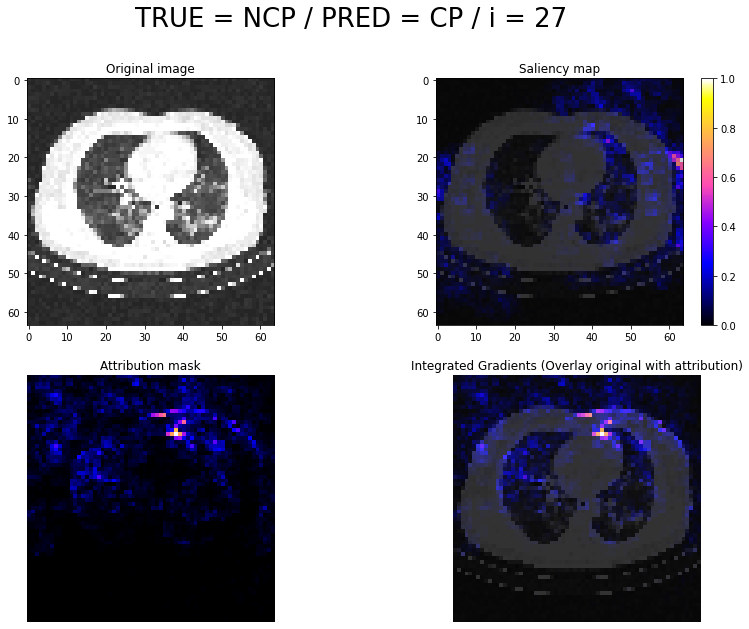

Adding explainability for input file CP/1/3143/0104.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0104.png


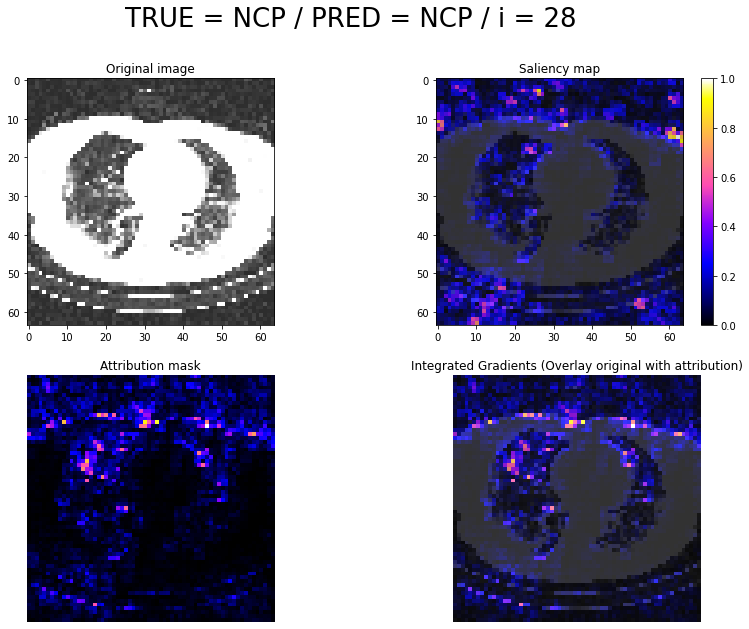

Adding explainability for input file CP/1/3143/0094.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0094.png


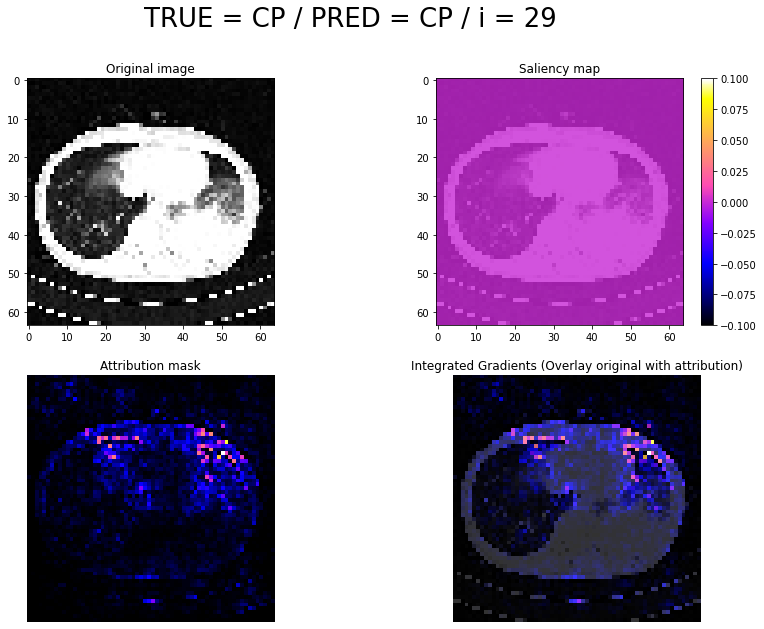

Adding explainability for input file CP/1/3143/0082.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0082.png


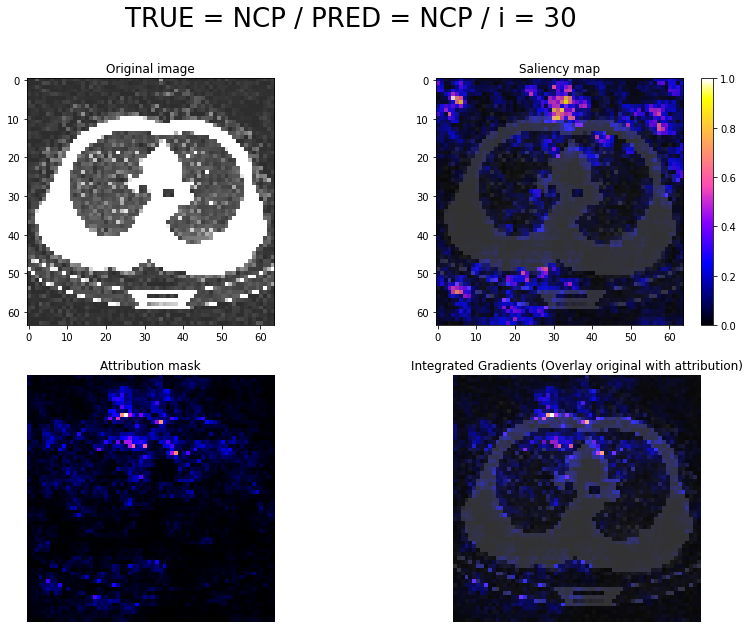

Adding explainability for input file CP/1/3143/0299.png, saving to file /home/albert/projects/tfg/docs/explainability/CP_1_3143_0299.png


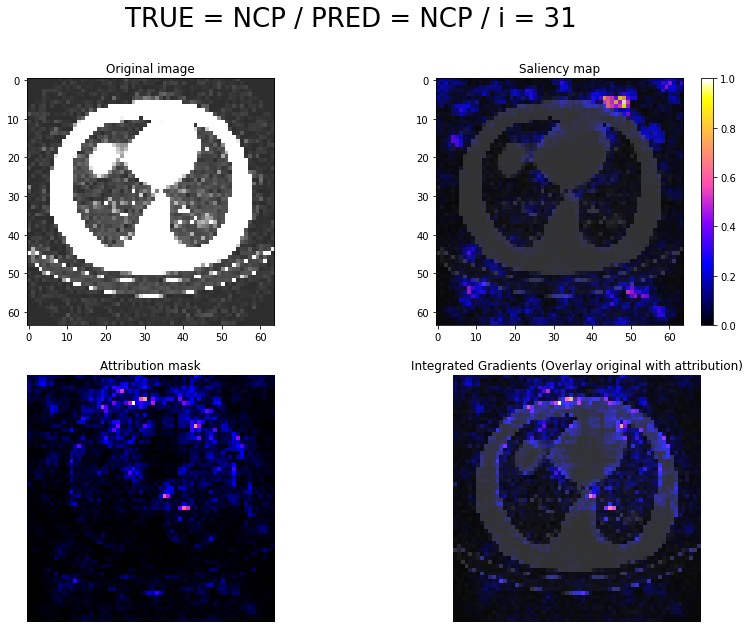

In [19]:
import numpy as np
num_images_to_explain = images_to_explain[0].shape[0]

# cmap = plt.cm.gnuplot2
# cmap = plt.cm.magma
# cmap = plt.cm.hot # also nice
# cmap = plt.cm.flag # really ugly, really easy to see what parts are relevant
# cmap = plt.cm.gist_rainbow # also ugly, also easy to see what parts are relevant
cmap = plt.cm.gnuplot2



for i in range(0, num_images_to_explain):
    src_file = images_to_explain_files[i]
    target_file = Path(imgs_output / src_file.replace("/", "_"))
    print(f"Adding explainability for input file {src_file}, saving to file {target_file}")
    target_class_idx = np.argmax(images_to_explain[1][i])
    true_label = idx_to_class[target_class_idx]
    img_arr = images_to_explain[0][i]
    img_batch = img_arr.reshape((1, *img_arr.shape))
    preds = model.predict(img_batch)
    pred_label = idx_to_class[np.argmax(preds)]
    plot_saliency_and_img_attributions(
        model, img_arr=img_arr,
        target_class_idx=target_class_idx, true_label=true_label, pred_label=pred_label,
        title_suffix=f"i = {i}", overlay_alpha=.2, cmap=cmap, save_to_file=target_file) ;
